In [1]:
import pickle
import sys
sys.path.append("../")

from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import lightning.pytorch as pl
import rasterio as rio
from rasterio.plot import show
import seaborn as sns
import shapely
import statsmodels.api as sm
from torch.utils.data import DataLoader

from openbustools import plotting, spatial, standardfeeds
from openbustools.traveltime import data_loader, model_utils
from openbustools.drivecycle import trajectory
from openbustools.drivecycle.physics import conditions, energy, vehicle

In [2]:
energy_model = energy.DriveCycleEnergyModel(vehicle.TransitBus(), conditions.AmbientConditions())

### Phone vs. Resampled-Predicted

In [3]:
# Load phone data
data_phone = pd.read_csv("../data/kcm_sensor/8124-33-2022-10-17_20-52-26/Location.csv")
short_name, veh_id = str.split(pd.read_csv("../data/kcm_sensor/8124-33-2022-10-17_20-52-26/Annotation.csv").iloc[0].text,"-")

# Create trajectory then drive cycle
phone_traj = trajectory.Trajectory(data_phone.longitude, data_phone.latitude, 300, 1, [386910,69022], 32148, known_times=data_phone['seconds_elapsed'].to_numpy())
phone_cycle = phone_traj.to_drivecycle("../data/kcm_spatial/usgs10m_dem_32148.tif")
cycle_df = phone_cycle.to_df()
cycle_df['F_aero'], cycle_df['F_grav'], cycle_df['F_roll'], cycle_df['F_acc'], cycle_df['F_tot'] = energy_model.calcTotalLoad(phone_cycle, combine=False)
cycle_df['P_motor'], cycle_df['P_regen'], cycle_df['P_aux'], cycle_df['P_tot'] = energy_model.calcTotalPower(phone_cycle, combine=False)
energy_model.printSummary(phone_cycle)
cycle_df.head()

9.437468766333584 kWh
1.5149260172137557 mi
6.229656537083526 Avg. kWh/mi


,Distance,Time,Elevation,Velocity,Acceleration,Slope,Theta,F_aero,F_grav,F_roll,F_acc,F_tot,P_motor,P_regen,P_aux,P_tot
0,1.994903,1.000000,37.365097,1.994902,1.330057,0.0,0.0,14.515927,0.0,1189.351439,19332.380329,20536.247695,52303.218770,0.000000,5154.639175,57457.857945
1,2.002018,1.000001,37.365097,2.002017,0.007115,0.0,0.0,14.619652,0.0,1189.368063,103.411451,1307.399166,3341.655278,0.000000,5154.639175,8496.294454
2,2.495136,1.000000,37.365097,2.495136,0.493119,0.0,0.0,22.708586,0.0,1190.664460,7167.489585,8380.862631,26697.383252,0.000000,5154.639175,31852.022428
3,1.310184,1.000000,37.365097,1.310184,-1.184952,0.0,0.0,6.261328,0.0,1188.028491,-17223.277348,-16028.987530,-0.000000,-7290.638349,5154.639175,-2135.999174
4,1.210923,1.000001,37.365097,1.210922,-0.099262,0.0,0.0,5.348526,0.0,1187.882198,-1442.774178,-249.543455,-0.000000,-104.903381,5154.639175,5049.735794


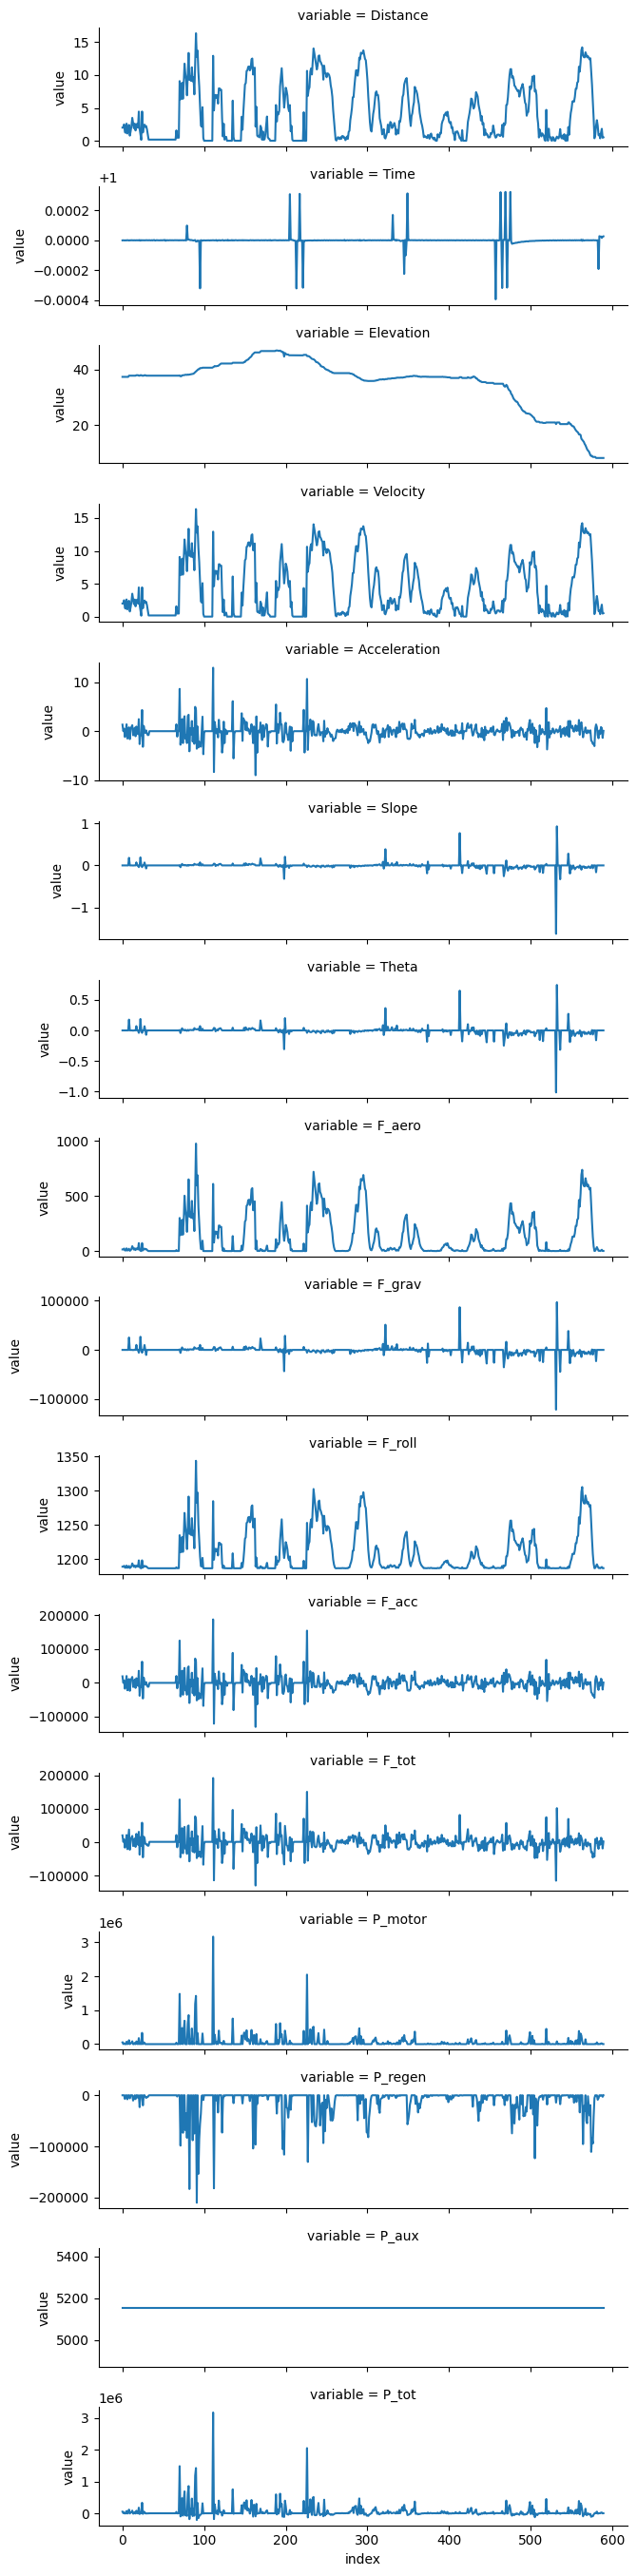

In [4]:
plotting.formatted_trajectory_lineplot(cycle_df)

In [5]:
# Create resampled trajectory
phone_traj = trajectory.Trajectory(data_phone.longitude, data_phone.latitude, 322, 0, [386910,69022], 32148, resample_len=60)
model = model_utils.load_model('../logs/', 'kcm', 'GRU', 0)
phone_traj.update_predicted_time(model)

# Create trajectory then drive cycle
phone_cycle = phone_traj.to_drivecycle("../data/kcm_spatial/usgs10m_dem_32148.tif")
cycle_df = phone_cycle.to_df()
cycle_df['F_aero'], cycle_df['F_grav'], cycle_df['F_roll'], cycle_df['F_acc'], cycle_df['F_tot'] = energy_model.calcTotalLoad(phone_cycle, combine=False)
cycle_df['P_motor'], cycle_df['P_regen'], cycle_df['P_aux'], cycle_df['P_tot'] = energy_model.calcTotalPower(phone_cycle, combine=False)
energy_model.printSummary(phone_cycle)
cycle_df.head()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zack/Desktop/open_bus_tools/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
2.4057834517816596 kWh
1.4396886394975084 mi
1.6710442701147838 Avg. kWh/mi


,Distance,Time,Elevation,Velocity,Acceleration,Slope,Theta,F_aero,F_grav,F_roll,F_acc,F_tot,P_motor,P_regen,P_aux,P_tot
0,20.027114,9.716122,37.966991,2.061225,0.162919,0.008525,0.008524,1.549717e+01,1214.224217,1189.508701,2368.027216,4787.257307,12597.893669,0.000000,5154.639175,17752.532844
1,11.099172,11.771081,37.958099,0.942919,-0.095005,-0.000801,-0.000801,3.243023e+00,-114.117629,1187.544753,-1380.891412,-304.221265,-0.000000,-99.584295,5154.639175,5055.054881
2,4.059714,7.217827,37.796268,0.562457,-0.052711,-0.039863,-0.039842,1.153930e+00,-5673.647024,1187.209938,-766.160843,-5251.443998,-0.000000,-1025.403509,5154.639175,4129.235666
3,0.002975,15.263379,37.796268,0.000195,-0.036837,0.000000,0.000000,1.385491e-07,0.000000,1187.025000,-535.430181,651.594819,0.162130,0.000000,5154.639175,5154.801306
4,0.318222,9.190127,37.796268,0.034626,0.003747,0.000000,0.000000,4.373389e-03,0.000000,1187.025701,54.456587,1241.486662,54.882772,0.000000,5154.639175,5209.521947


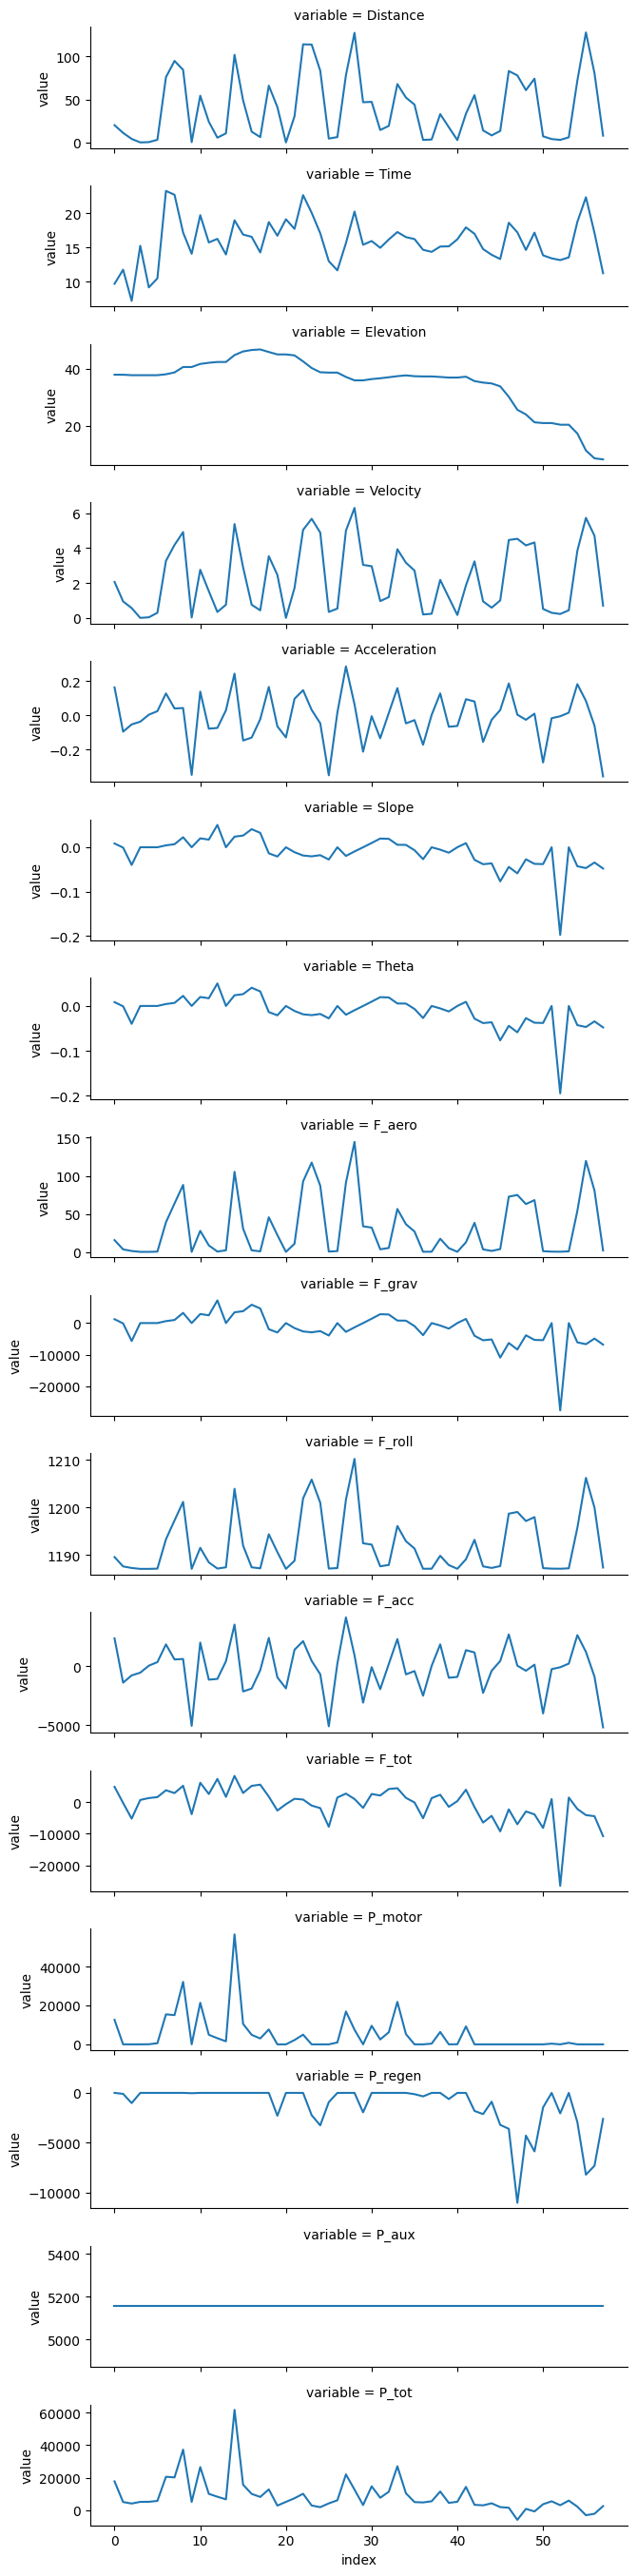

In [6]:
plotting.formatted_trajectory_lineplot(cycle_df)

In [7]:
# Create resampled trajectory
phone_traj = trajectory.Trajectory(data_phone.longitude, data_phone.latitude, 322, 0, [386910,69022], 32148, resample_len=60)
model = pickle.load(open(f"../logs/kcm/AVG-0.pkl", 'rb'))
phone_traj.update_predicted_time(model)

# Create trajectory then drive cycle
phone_cycle = phone_traj.to_drivecycle("../data/kcm_spatial/usgs10m_dem_32148.tif")
cycle_df = phone_cycle.to_df()
cycle_df['F_aero'], cycle_df['F_grav'], cycle_df['F_roll'], cycle_df['F_acc'], cycle_df['F_tot'] = energy_model.calcTotalLoad(phone_cycle, combine=False)
cycle_df['P_motor'], cycle_df['P_regen'], cycle_df['P_aux'], cycle_df['P_tot'] = energy_model.calcTotalPower(phone_cycle, combine=False)
energy_model.printSummary(phone_cycle)
cycle_df.head()

2.192252137825479 kWh
1.4396886394975084 mi
1.522726565787611 Avg. kWh/mi


,Distance,Time,Elevation,Velocity,Acceleration,Slope,Theta,F_aero,F_grav,F_roll,F_acc,F_tot,P_motor,P_regen,P_aux,P_tot
0,20.027114,2.910497,37.966991,6.880994,-0.116581,0.008525,0.008524,172.704620,1214.224217,1214.704026,-1694.506917,907.125947,7969.012295,0.000000,5154.639175,13123.651471
1,11.099172,1.600774,37.958099,6.933630,0.032882,-0.000801,-0.000801,175.356953,-114.117629,1215.129110,477.938940,1754.307374,15529.308351,0.000000,5154.639175,20683.947526
2,4.059714,0.582099,37.796268,6.974262,0.069802,-0.039863,-0.039842,177.418195,-5673.647024,1215.459462,1014.574600,-3266.194767,-0.000000,-7908.013427,5154.639175,-2753.374252
3,0.002975,5.633539,37.796268,0.000528,-1.237896,0.000000,0.000000,0.000001,0.000000,1187.025000,-17992.815604,-16805.790603,-0.000000,-3.080750,5154.639175,5151.558425
4,0.318222,5.633539,37.796268,0.056487,0.009933,0.000000,0.000000,0.011639,0.000000,1187.026865,144.378761,1331.417265,96.017059,0.000000,5154.639175,5250.656234


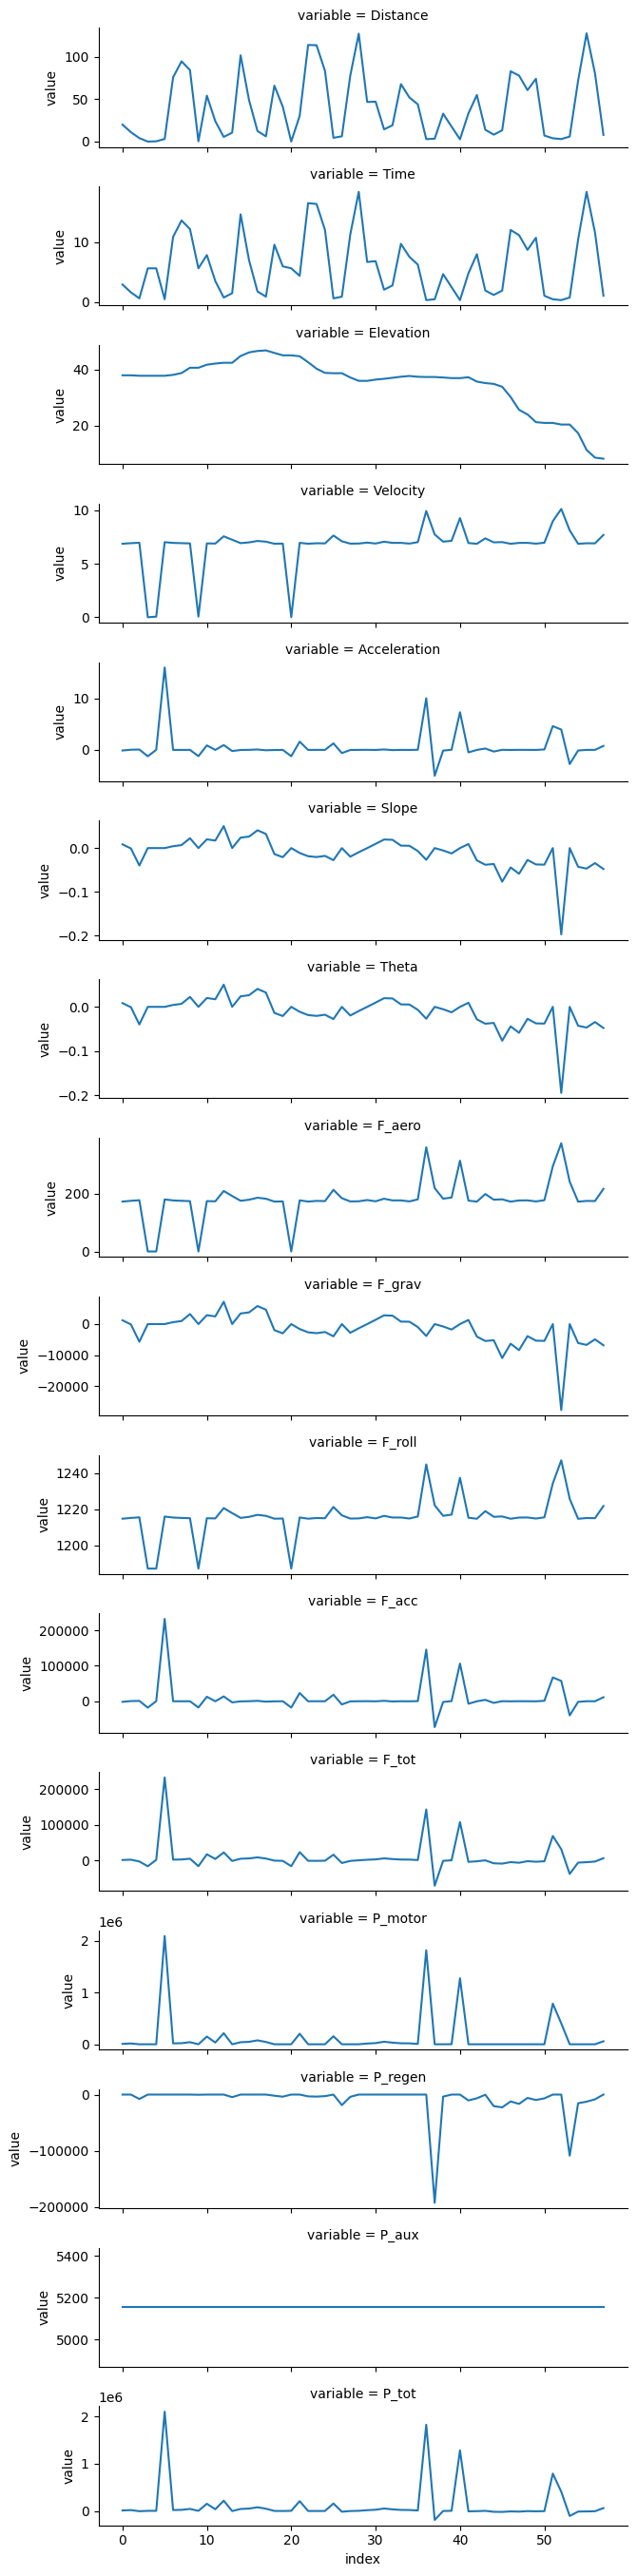

In [8]:
plotting.formatted_trajectory_lineplot(cycle_df)

In [ ]:
# GTFS shapes
shape_lookup = standardfeeds.get_gtfs_shapes_lookup(f"../data/kcm_gtfs/{static_date}/")
shapes = standardfeeds.get_gtfs_shapes(f"../data/kcm_gtfs/{static_date}/").to_crs("EPSG:32148")
shapes.plot()

In [ ]:
route_ids = pd.unique(data_gtfs[(data_gtfs['route_short_name']==short_name) & (data_gtfs['direction_id']==0)].route_id)
phone_shape = shapes[(shapes['route_id'].isin(route_ids)) & (shapes['direction_id']==0) & (shapes['service_id']==21133)]

In [ ]:
# Get one shape to work with
sample_service_id, sample_route_id, sample_direction_id = data_gtfsrt.groupby(['service_id','route_id','direction_id']).count().index[0]
print(sample_service_id, sample_route_id, sample_direction_id)

# GTFS-RT
sample_realtime = data_gtfsrt[(data_gtfsrt['service_id']==sample_service_id) & (data_gtfsrt['route_id']==sample_route_id) & (data_gtfsrt['direction_id']==sample_direction_id)].copy()

# Shape
sample_shape = shapes[(shapes['service_id']==sample_service_id) & (shapes['route_id']==sample_route_id) & (shapes['direction_id']==sample_direction_id)].copy()
sample_shape.plot()

In [ ]:
# Get distance along shape
sample_realtime['dist_along_line'] = sample_realtime['geometry'].apply(lambda pt: shapely.line_locate_point(sample_shape.geometry, pt))
# sample_static['dist_along_line'] = sample_static['geometry'].apply(lambda pt: shapely.line_locate_point(sample_shape.geometry, pt))

# Also get a timestamp column on the samples
sample_realtime['t'] = pd.to_datetime(sample_realtime['locationtime'], unit='s')
sample_realtime = sample_realtime.set_index('t')

In [ ]:
# ax = sns.lineplot(sample_static, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False).set_ylim(0,25)

In [ ]:
sns.lineplot(sample_realtime, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False).set_ylim(0,25)

In [ ]:
plotting.formatted_basemap_scatterplot(sample_realtime)

In [ ]:
plotting.formatted_basemap_scatterplot(sample_shape)

In [ ]:
filtered = sm.nonparametric.lowess(endog=sample_realtime['calc_speed_m_s'], exog=sample_realtime['dist_along_line'], frac=0.01, it=1)
axes = sns.lineplot(sample_realtime, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False)
sns.lineplot(x=filtered[:,0], y=filtered[:,1], ax=axes, color='black')

In [ ]:
# Compute the 95% confidence interval
eval_x = np.linspace(0, max(sample_realtime['dist_along_line'].values))
smoothed, bottom, top = plotting.lowess_with_confidence_bounds(sample_realtime['dist_along_line'].values, sample_realtime['calc_speed_m_s'].values, eval_x, lowess_kw={"frac": 0.01})
axes = sns.lineplot(sample_realtime, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False)
# axes.set_xlim(0,5000)
# axes.set_ylim(0,20)
sns.lineplot(x=eval_x, y=smoothed, color='black', ax=axes)
sns.lineplot(x=eval_x, y=top, color='blue', ax=axes)
sns.lineplot(x=eval_x, y=bottom, color='blue', ax=axes)

In [ ]:
data_phone['dist_along_line'] = data_phone['geometry'].apply(lambda pt: shapely.line_locate_point(phone_shape.geometry, pt))


In [ ]:
fig, axes = plotting.formatted_basemap_scatterplot(data_phone)
phone_shape.plot(ax=axes, color='black')

In [ ]:
sns.lineplot(data_phone, x='dist_along_line', y='calc_speed_m_s')

### Trip GPS Points

In [ ]:
data_phone = pd.read_csv("../data/kcm_sensor/8124-33-2022-10-17_20-52-26/Location.csv")
short_name, veh_id = str.split(pd.read_csv("../data/kcm_sensor/8124-33-2022-10-17_20-52-26/Annotation.csv").iloc[0].text,"-")
data_phone = gpd.GeoDataFrame(data_phone, geometry=gpd.points_from_xy(data_phone.longitude, data_phone.latitude), crs="EPSG:4326").to_crs("EPSG:32148")
_, _, data_phone['calc_speed_m_s'] = spatial.calculate_speed(data_phone, 'seconds_elapsed')
plotting.formatted_basemap_scatterplot(data_phone, "Phone Basemap")

In [ ]:
data_gtfs = data_utils.merge_gtfs_files("../data/kcm_gtfs/2023_05_14/", epsg="32148", coord_ref_center=[386910,69022])
gtfs_calendar = pd.read_csv("../data/kcm_gtfs/2023_05_14/calendar.txt")
filtered_gtfs, remaining_trip_ids = data_utils.filter_gtfs_w_phone(data_phone, data_gtfs, short_name, gtfs_calendar)
filtered_gtfs = gpd.GeoDataFrame(filtered_gtfs, geometry=gpd.points_from_xy(filtered_gtfs.stop_lon, filtered_gtfs.stop_lat), crs="EPSG:4326").to_crs("EPSG:32148")
filtered_gtfs['seconds_elapsed'] = filtered_gtfs['arrival_s'] - filtered_gtfs['arrival_s'].iloc[0]
_, _, filtered_gtfs['calc_speed_m_s'] = spatial.calculate_speed(filtered_gtfs, 'seconds_elapsed')
plotting.formatted_basemap_scatterplot(filtered_gtfs, "GTFS Basemap")

In [ ]:
data_gtfsrt = pd.read_pickle("../data/kcm_realtime/2023_05_20.pkl")
data_gtfsrt['locationtime'] = pd.to_numeric(data_gtfsrt['locationtime'])
filtered_gtfsrt_daily = data_gtfsrt[data_gtfsrt['trip_id'].isin(remaining_trip_ids)]
filtered_gtfsrt_one = filtered_gtfsrt_daily[filtered_gtfsrt_daily['trip_id']==remaining_trip_ids[0]]
filtered_gtfsrt_one = gpd.GeoDataFrame(filtered_gtfsrt_one, geometry=gpd.points_from_xy(filtered_gtfsrt_one.lon, filtered_gtfsrt_one.lat), crs="EPSG:4326").to_crs("EPSG:32148")
filtered_gtfsrt_one['seconds_elapsed'] = filtered_gtfsrt_one['locationtime'] - filtered_gtfsrt_one['locationtime'].iloc[0]
_, _, filtered_gtfsrt_one['calc_speed_m_s'] = spatial.calculate_speed(filtered_gtfsrt_one, 'locationtime')
plotting.formatted_basemap_scatterplot(filtered_gtfsrt_one, "GTFS-RT Basemap One Trip")

In [ ]:
filtered_gtfsrt_daily = gpd.GeoDataFrame(filtered_gtfsrt_daily, geometry=gpd.points_from_xy(filtered_gtfsrt_daily.lon, filtered_gtfsrt_daily.lat), crs="EPSG:4326").to_crs("EPSG:32148")
filtered_gtfsrt_daily['seconds_elapsed'] = filtered_gtfsrt_daily['locationtime'] - filtered_gtfsrt_daily['locationtime'].iloc[0]
_, _, filtered_gtfsrt_daily['calc_speed_m_s'] = spatial.calculate_speed(filtered_gtfsrt_daily, 'locationtime')
plotting.formatted_basemap_scatterplot(filtered_gtfsrt_daily, "GTFS-RT Basemap Daily Trips")

### Drive Cycles

In [ ]:
data_melt_phone = pd.melt(data_phone, id_vars=['seconds_elapsed'], value_vars=['speed','calc_speed_m_s','altitudeAboveMeanSeaLevel'])
plotting.formatted_rel_lineplot(data_melt_phone, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='Phone Speed')

In [ ]:
filtered_melt_gtfs = pd.melt(filtered_gtfs, id_vars=['seconds_elapsed'], value_vars=['calc_speed_m_s'])
plotting.formatted_rel_lineplot(filtered_melt_gtfs, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='GTFS Speed', xlim=(0,2000), ylim=(0,35))

In [ ]:
filtered_melt_gtfsrt_one = pd.melt(filtered_gtfsrt_one, id_vars=['seconds_elapsed'], value_vars=['calc_speed_m_s'])
plotting.formatted_rel_lineplot(filtered_melt_gtfsrt_one, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='GTFS-RT Drive Cycle One Trip', xlim=(0,2000), ylim=(0,35))

In [ ]:
filtered_melt_gtfsrt_daily = pd.melt(filtered_gtfsrt_daily, id_vars=['seconds_elapsed'], value_vars=['calc_speed_m_s'])
plotting.formatted_rel_lineplot(filtered_melt_gtfsrt_daily, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='GTFS-RT Drive Cycle Daily Trips')